In [28]:
import matplotlib.pyplot as plt

import pymongo
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['font.size'] = 25

db = pymongo.MongoClient("mongodb://localhost:27017/")['Jan16_cloudseg_saliency_loss']

In [31]:
approach1 = 'backprop_sigmoid_saliency_error'
approach2 = 'backprop_sigmoid_feature_error'

0.925151597460111
0.9152103761831919


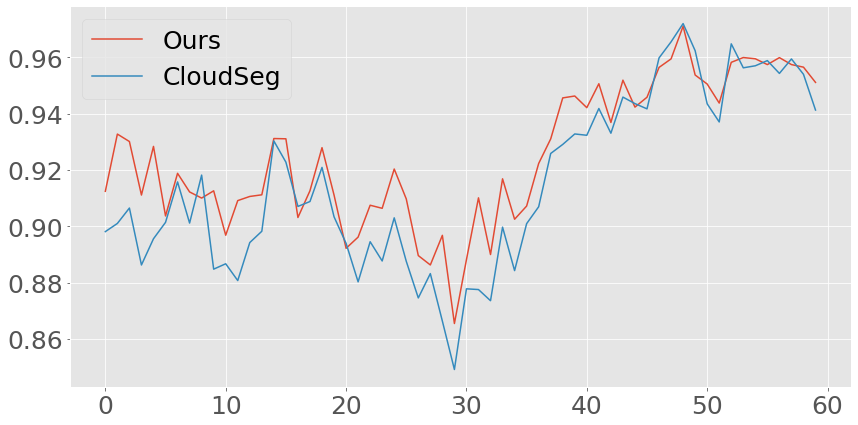

In [35]:


import numpy as np
def query_approach(ax, approach, label):
    f1s = []

    for sec in range(1, 61):

        query = {
            'second': sec,
            'command_line_args.approach': approach,
        }

        x = list(db['stats'].find(query))
        x = sorted(x, key = lambda x: x['_id'])
        f1s.append(x[-1])


    ax.plot(range(len(f1s)), [i['f1'] for i in f1s], label=label)
    print(np.array([i['f1'] for i in f1s]).mean())
    

fig, ax = plt.subplots(figsize=(14, 7))

query_approach(ax, approach1, 'Ours')
query_approach(ax, approach2, 'CloudSeg')
ax.legend()

In [22]:
f1s

[{'_id': ObjectId('61e4de12d3ce51681cd4e094'),
  'app': 'EfficientDet_d2',
  'qp': 0,
  'res': '640x360',
  'fr': 10,
  'cloudseg': True,
  'input': 'videos/dashcam/dashcam_126/part%d.mp4',
  'second': 1,
  'command_line_args': {'loss_type': 'saliency_error',
   'input': 'videos/dashcam/dashcam_126/part%d.mp4',
   'start': 0,
   'end': 61,
   'num_iterations': 1,
   'frequency': 3,
   'app': 'EfficientDet-d2',
   'average_window_size': 17,
   'approach': 'backprop_sigmoid_saliency_error'},
  'settings': {'VIDEO_NAME': 'videos/dashcam/dashcam_126/part%d.mp4',
   'NUM_SEGMENTS': 61,
   'COLLECTION_NAME': 'Jan16_cloudseg_saliency_loss',
   'ENABLE_CLOUDSEG': True,
   'CONFIGURATION_SPACE': {'reducto_pixel': [0.2, 0.25, 0.3, 0.35, 0.4],
    'reducto_area': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
    'reducto_edge': [0.0075, 0.008, 0.0085, 0.009, 0.0095]},
   'BACKPROP': {'lr': 0.2,
    'bw_weight': 20,
    'train': True,
    'std_score_mean_weight': 0,
    'compute_weight': 0.04,
    'sum_score